# Graduate Project of CNN Regression version 5.0 - Stacking

## Initialize machine learning library

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
print(torch.__version__)

2.6.0+cpu


### Set computing device as CPU

In [3]:
device = torch.device("cpu")
print(f"Using Device: {device}")

Using Device: cpu


## Data load in and pre-processing

In [4]:
features = pd.read_csv("/home/seb/Project/BEng-Graduate/data/data.csv", header=None)
features = features.transpose()
# features = data.values.T.astype(np.float32)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,500,501,502,503,504,505,506,507,508,509
0,70.0,200.0,300.0,28.801196,81.105366,6125.0,5690.0,6560.0,870.0,-120.782809,...,-118.949780,-118.499691,-118.020283,-117.503018,-116.936596,-116.305609,-115.588315,-114.752730,-113.749309,-112.495888
1,70.0,200.0,400.0,2.517709,47.612011,3860.0,3840.0,3880.0,40.0,-121.070769,...,-116.630247,-116.579676,-116.529680,-116.480227,-116.431285,-116.382825,-116.334820,-116.287244,-116.240073,-116.193283
2,70.0,200.0,500.0,3.068820,63.245190,3945.0,3920.0,3970.0,50.0,-121.322709,...,-113.516857,-113.319928,-113.096880,-112.840765,-112.541882,-112.186250,-111.752916,-111.208943,-110.499310,-109.524470
3,70.0,200.0,600.0,5.874144,55.115136,4050.0,4000.0,4100.0,100.0,-121.477196,...,-108.600004,-104.475919,-92.225585,-111.170745,-123.172305,-140.835187,-127.837068,-124.087345,-122.231465,-121.097501
4,70.0,200.0,700.0,-123.202804,67.654798,3635.0,4160.0,3110.0,-1050.0,-121.156614,...,-116.668022,-116.650467,-116.633328,-116.616634,-116.600387,-116.584503,-116.569146,-116.554043,-116.539304,-116.524892


Check data shape

In [5]:
print("data dimension:", features.shape)

data dimension: (392, 510)


### Draw original feature-describing histograms

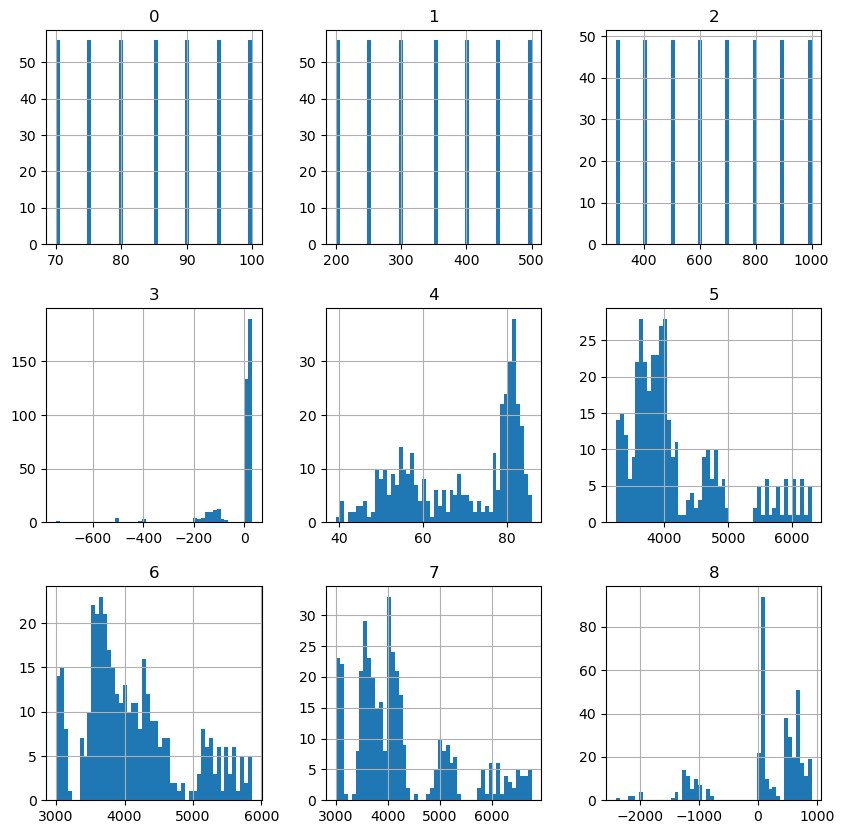

In [6]:
fea = features.iloc[:, :9]
fea.hist(bins=50, figsize=(10,10))
plt.show()

### Set label and transform it into a nparray

In [7]:
labels = np.array(features.iloc[:,9:])
features = np.array(features.iloc[:, 1:9])
features.shape

(392, 8)

## Exploratory Data Analysis

### Show the variation of respective features

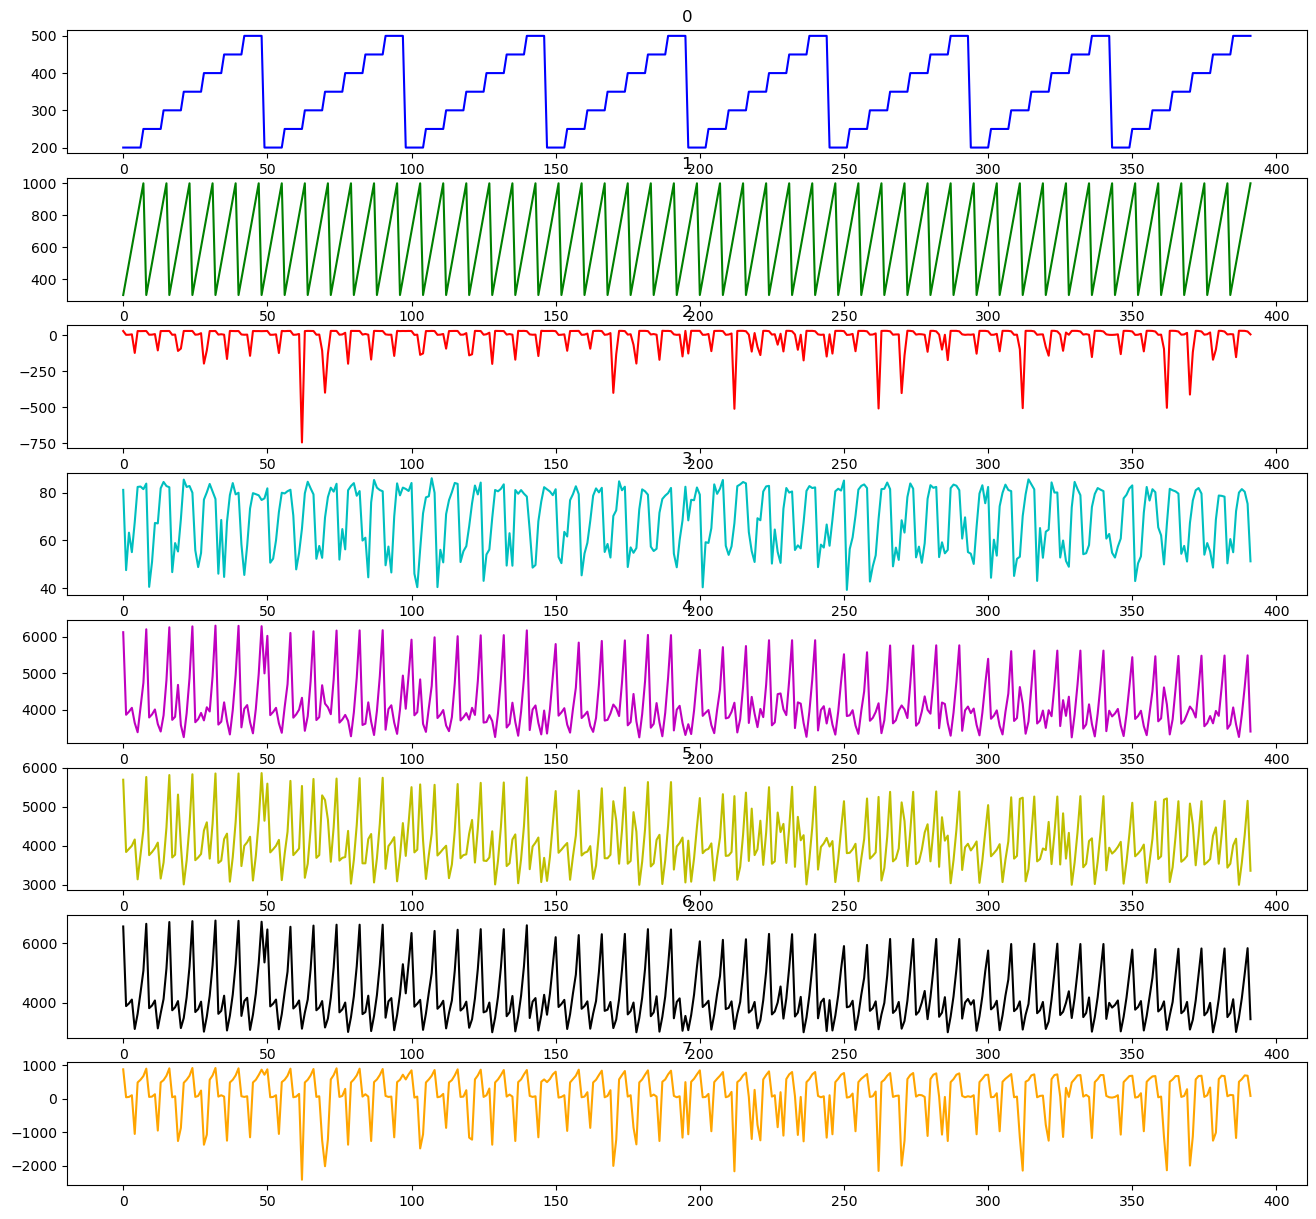

In [8]:
plt.figure(figsize=(16,15))
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500']
for i in range(8):
  plt.subplot(8,1, i+1)
  a, = plt.plot(features[:,i],color= color[i])
  plt.title(i)

plt.show()

### Data standardization using sklearn

In [9]:
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
input_features = preprocessing.StandardScaler().fit_transform(features)
input_labels = preprocessing.MinMaxScaler().fit_transform(labels)
input_features[0]

array([-1.5       , -1.52752523,  0.47353794,  0.91441986,  2.55646587,
        2.22862805,  2.44093019,  1.07199055])

### Normalized Data Describing

In [10]:
x = pd.DataFrame({
    'LN层厚': input_features[:, 0],
    '半波长': input_features[:, 1],
    '机电耦合系数': input_features[:, 2],
    '声速': input_features[:, 3],
    '反谐振频率': input_features[:, 4],
    '谐振频率': input_features[:, 5],
    '中心频率': input_features[:, 6],
    '带宽': input_features[:, 7]
})
print(x.describe())

             LN层厚         半波长      机电耦合系数            声速         反谐振频率  \
count  392.000000  392.000000  392.000000  3.920000e+02  3.920000e+02   
mean     0.000000    0.000000    0.000000  5.922700e-15  1.404772e-16   
std      1.001278    1.001278    1.001278  1.001278e+00  1.001278e+00   
min     -1.500000   -1.527525   -7.887734 -2.260179e+00 -1.206716e+00   
25%     -1.000000   -0.763763    0.195515 -9.642557e-01 -6.784355e-01   
50%      0.000000    0.000000    0.285136  3.210611e-01 -3.164657e-01   
75%      1.000000    0.763763    0.478904  9.102872e-01  5.232390e-01   
max      1.500000    1.527525    0.494375  1.285404e+00  2.791257e+00   

               谐振频率          中心频率            带宽  
count  3.920000e+02  3.920000e+02  3.920000e+02  
mean   3.353327e-16  4.531523e-18 -4.984675e-17  
std    1.001278e+00  1.001278e+00  1.001278e+00  
min   -1.555052e+00 -1.280045e+00 -3.610607e+00  
25%   -6.829771e-01 -6.633667e-01 -9.865882e-02  
50%   -2.469396e-01 -2.348274e-01  1.08346

### Test features correlations

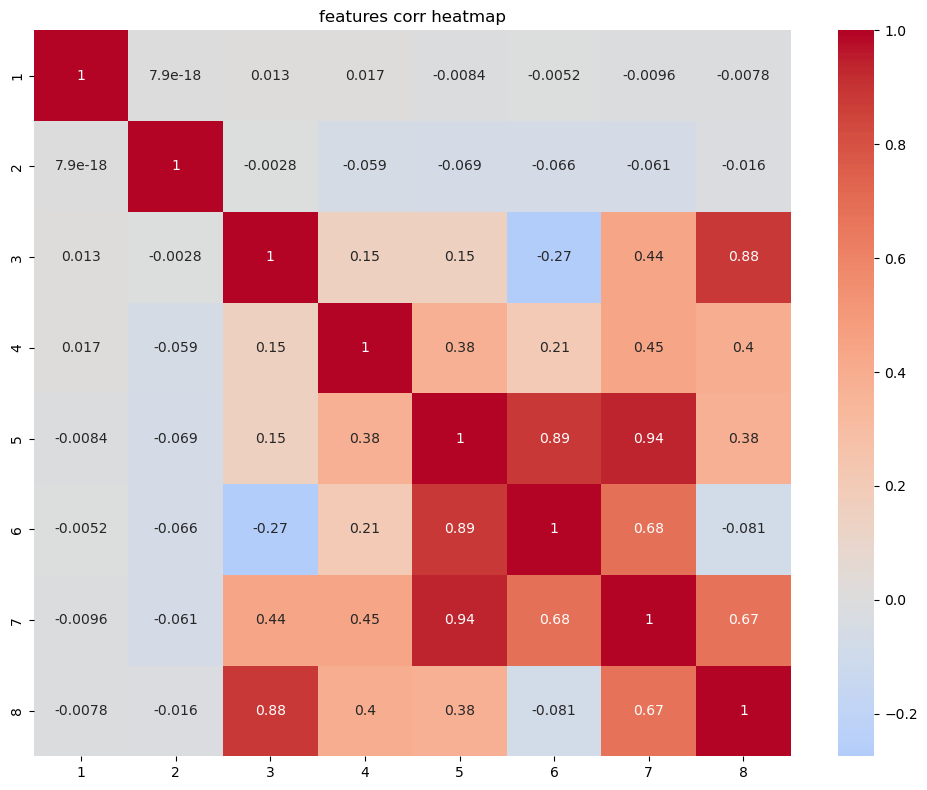

In [97]:
corr_matrix = x.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('features corr heatmap')
plt.tight_layout()
plt.show()

### Show histograms of standardized-features

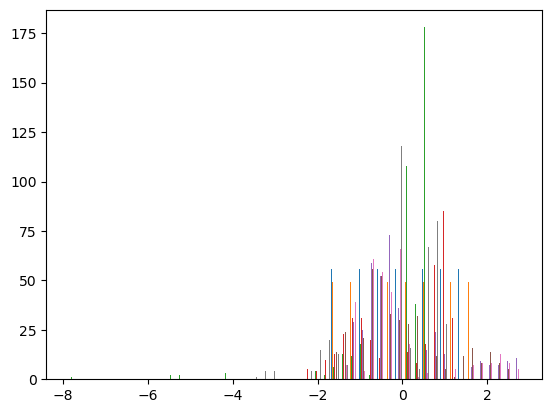

In [98]:
plt.hist(input_features, bins=50)
plt.show()

## Split data set into training and validating

In [99]:
x_train, x_val, y_train, y_val = train_test_split(input_features, input_labels, train_size = 0.8, shuffle = True, random_state = 2019)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1, 8)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32).reshape(-1, 1, 8)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

check set tpye

### PCA decomposition

In [100]:
pca = PCA(n_components = 100)
y_train_reduced = pca.fit_transform(y_train)

### Set up XGBoost Regression model

In [101]:
xgbr = XGBRegressor(
    objective = "reg:squarederror", 
    n_estimators = 300, 
    max_depth = 8, 
    learning_rate = 0.01,
    subsample = 0.7,
    colsample_bytree = 1.0
)

In [102]:
# xgbr.fit(x_train, y_train)
xgbr.fit(x_train, y_train_reduced)
xgb_train_pred = pca.inverse_transform(xgbr.predict(x_train))
xgb_test_pred = pca.inverse_transform(xgbr.predict(x_val))

## Constract Convolutional Neural Network

### Import torch libraries

In [103]:
import torch.nn as nn
from torch.nn import Conv1d 
from torch.nn import MaxPool1d 
from torch.nn import Flatten 
from torch.nn import AvgPool1d
from torch.nn import BatchNorm1d
from torch.nn import Linear 
from torch.utils.data import DataLoader, TensorDataset 
import torch.optim as optim
import torch.nn.functional as F

### Define Hyper-parameters and set dataloader

In [111]:
input_size = 1
output_size = 501
num_epochs = 50
batch_size = 16

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### Set up CNN module

In [112]:
class CNNRegressor(nn.Module):
    def __init__(self, inputs, outputs):
        super(CNNRegressor, self).__init__()
        self.inputs = inputs
        self.outputs = outputs

        # Convolution Sequence 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                inputs, 
                16, 
                kernel_size = 3,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2)
        )

        # Convolution Sequence 2 with Batch Normalization and AP
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(num_features = 64),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size = 2)
        )

        # Convolution Sequence 3 with 2 convolutional layers
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(num_features = 128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(num_features = 256),
            nn.ReLU()
        )

        # Convolution Sequence 4 with flatten and FC layers
        self.conv4 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU()
        )

        self.out = nn.Linear(512, outputs)

    # Forward function
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # print("Before Flatten: ", x.shape)
        x = self.conv4(x)
        # print("After Flatten: ", x.shape)
        x = self.out(x)
        return x

### Training CNN model

In [118]:
# Instantiation
model = CNNRegressor(input_size, output_size)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01)
# optimizer = SGD(model.parameters(), lr = 1e-7)
# optimizer = Adagrad(model.parameters(), lr= 1e-5)
# optimizer = Adam(model.parameters(), lr = 1e-6 )
# optimizer = RMSprop(model.parameters(), lr = 1e-6 )

# Looping
for epoch in range(num_epochs):
    # Training mode
    model.train()  
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward
        optimizer.zero_grad()  # Empty grad
        loss.backward()        # Compute grad
        optimizer.step()        # Update parameters

        running_loss += loss.item() # Update loss

    # Computer loss
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}")

model.eval()  # Evaluation mode
with torch.no_grad():
    cnn_train_pred = model(x_train_tensor)
    cnn_test_pred = model(x_val_tensor)

print("Training Complete.")

Epoch 1, Loss: 295.4075
Epoch 2, Loss: 0.2297
Epoch 3, Loss: 0.1505
Epoch 4, Loss: 0.0572
Epoch 5, Loss: 0.0332
Epoch 6, Loss: 0.0277
Epoch 7, Loss: 0.0269
Epoch 8, Loss: 0.0254
Epoch 9, Loss: 0.0227
Epoch 10, Loss: 0.0225
Epoch 11, Loss: 0.0195
Epoch 12, Loss: 0.0198
Epoch 13, Loss: 0.0192
Epoch 14, Loss: 0.0186
Epoch 15, Loss: 0.0183
Epoch 16, Loss: 0.0189
Epoch 17, Loss: 0.0184
Epoch 18, Loss: 0.0179
Epoch 19, Loss: 0.0182
Epoch 20, Loss: 0.0189
Epoch 21, Loss: 0.0182
Epoch 22, Loss: 0.0175
Epoch 23, Loss: 0.0186
Epoch 24, Loss: 0.0186
Epoch 25, Loss: 0.0186
Epoch 26, Loss: 0.0183
Epoch 27, Loss: 0.0202
Epoch 28, Loss: 0.0215
Epoch 29, Loss: 0.0185
Epoch 30, Loss: 0.0190
Epoch 31, Loss: 0.0176
Epoch 32, Loss: 0.0191
Epoch 33, Loss: 0.0187
Epoch 34, Loss: 0.0181
Epoch 35, Loss: 0.0194
Epoch 36, Loss: 0.0185
Epoch 37, Loss: 0.0193
Epoch 38, Loss: 0.0208
Epoch 39, Loss: 0.0185
Epoch 40, Loss: 0.0198
Epoch 41, Loss: 0.0191
Epoch 42, Loss: 0.0190
Epoch 43, Loss: 0.0217
Epoch 44, Loss: 0.

## Stacking

In [119]:
meta_train = np.hstack([cnn_train_pred, xgb_train_pred])
meta_test = np.hstack([cnn_test_pred, xgb_test_pred])

# use Ridge Regression as Meta Learner
meta_model = PLSRegression(n_components = 8)
meta_model.fit(meta_train, y_train)

PLSRegression(n_components=8)

In [120]:
predictions = meta_model.predict(meta_test)

### Compare predictions to actural values

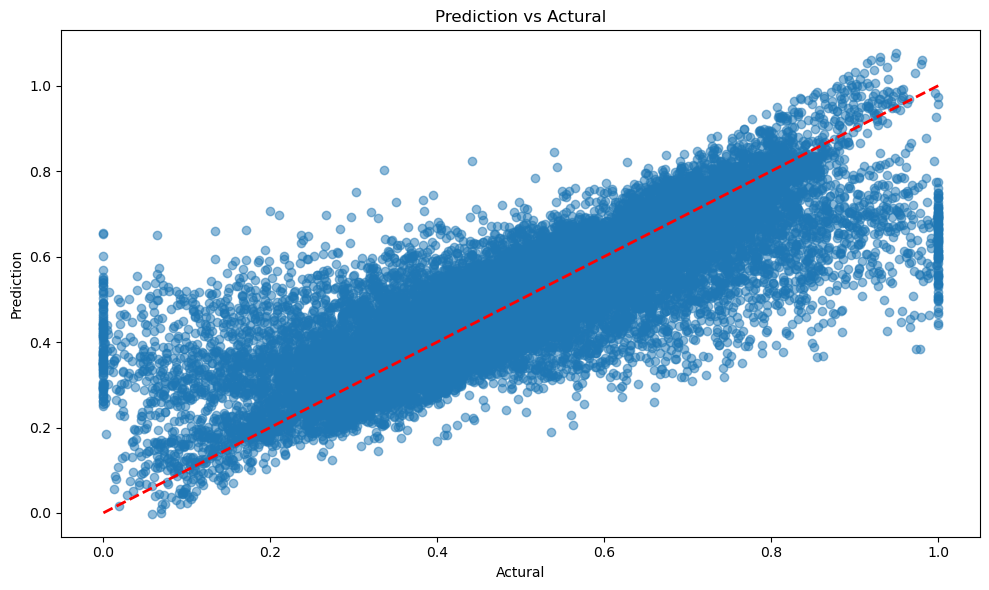

In [121]:
# Compare actural values with prediction
plt.figure(figsize = (10, 6))
plt.scatter(y_val, predictions, alpha=0.5)
plt.plot([targets.max(), targets.min()], [targets.max(), targets.min()], 'r--', lw=2)

# Set graph config
plt.xlabel('Actural'); plt.ylabel('Prediction'); plt.title('Prediction vs Actural')
plt.tight_layout()
plt.show()

In [122]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(predictions, y_val)
r2 = r2_score(predictions, y_val)

print("MSE: ", mse)
print("R^2 :", r2)

MSE:  0.007355752938831173
R^2 : -0.8973309978628723
